# 💻 Romlig kobling

*Romlige koblinger* er operasjoner som kombinerer data fra to eller flere romlige datasett
basert på deres geometriske relasjon. I de forrige delene fikk vi
kjennskap til to spesifikke tilfeller av romlige koblinger: [Punkt-i-polygon
spørringer](punkt_i_polygon) og [Intersect](intersect). 

Romlige koblingsoperasjoner krever to inngangsparametere: *predikatet*, dvs. den
geometriske betingelsen som må oppfylles mellom to geometrier, og
*koblings-typen*: om bare rader med matchende geometrier beholdes, eller alle radene i en
inputtabell, eller alle radene fra begge tabellene.

*Geopandas* (ved hjelp av `shapely` for å implementere geometriske forhold) [støtter et
standard sett med geometriske
predikater](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#binary-predicate-joins),
som ligner de fleste GIS analyseverktøy og progammer bruker:

- intersects
- contains
- within
- touches
- crosses
- overlaps

Geometriske predikater uttrykkes som verb, så de har en intuitiv
betydning. Se [shapely bruker
manual](https://shapely.readthedocs.io/en/stable/manual.html#binary-predicates)
for en detaljert beskrivelse av hvert geometrisk predikat.


:::{admonition} Binære geometriske predikater
:class: hint

Shapely støtter flere *binære geometriske predikater* enn geopandas implementerer
for romlige koblinger. Hva er de? Kan de uttrykkes ved å kombinere de
som allerede er implementerte?
:::

Når det gjelder *koblings-typen*, implementerer geopandas tre forskjellige alternativer:

- *left*: behold alle poster av *left* data-rammen, fyll med tomme verdier hvis
  ingen match, behold *left* geometrikolonne
- *right*: behold alle poster av *left* data-rammen, fyll med tomme verdier hvis
  ingen match, behold *right* geometrikolonne
- *inner*: behold bare poster av matchende poster, behold *left* geometrikolonne

![Romlige koblinger](https://pygis.io/_images/join_types.jpg)

:::{tip}
[PyGIS
boken](https://pygis.io/docs/e_spatial_joins.html) har en god oversikt over
romlige predikater og koblings-typer med forklarende tegninger.
:::


---


## Last inn inngangsdata

Som et praktisk eksempel, la oss finne befolkningstettheten på hver av
adressene fra [tidligere i denne leksjonen](#05_geokoding_i_geopandas), ved å kombinere
datasettet med data fra et befolkningsnett.

Befolkningsnettdata er tilgjengelig fra [SSB](https://kart.ssb.no/).

In [2]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_MAPPE = NOTEBOOK_PATH / "data"

In [4]:
import geopandas

adresser = geopandas.read_file(DATA_MAPPE / "oslo_adresser" / "adresser.gpkg")

befolkningsnett = geopandas.read_file(DATA_MAPPE / "ssb_rutenett" / "befolkning_250m_2023_oslo.gpkg"
)

In [5]:
befolkningsnett.head()

,ru250m,pop_tot,geometry
0,22637506643000,14,"MULTIPOLYGON (((264000.000 6643000.000, 263750..."
1,22640006643000,177,"MULTIPOLYGON (((264250.000 6643000.000, 264000..."
2,22642506643000,169,"MULTIPOLYGON (((264500.000 6643000.000, 264250..."
3,22645006643000,261,"MULTIPOLYGON (((264750.000 6643000.000, 264500..."
4,22647506643000,106,"MULTIPOLYGON (((265000.000 6643000.000, 264750..."


Til slutt, beregn befolkningstettheten ved å dele antall innbyggere
av hver rutenettcelle med arealet i km²:

In [7]:
befolkningsnett["pop_density"] = (
    befolkningsnett["pop_tot"]
    / (befolkningsnett.area / 1_000_000)
)
befolkningsnett.head()

,ru250m,pop_tot,geometry,pop_density
0,22637506643000,14,"MULTIPOLYGON (((264000.000 6643000.000, 263750...",224.000000
1,22640006643000,177,"MULTIPOLYGON (((264250.000 6643000.000, 264000...",2832.000001
2,22642506643000,169,"MULTIPOLYGON (((264500.000 6643000.000, 264250...",2704.000001
3,22645006643000,261,"MULTIPOLYGON (((264750.000 6643000.000, 264500...",4176.000002
4,22647506643000,106,"MULTIPOLYGON (((265000.000 6643000.000, 264750...",1696.000001


:::{admonition} Kodestil: store tall, operatorer i flerlinjeuttrykk
:class: tip

Hvis du trenger å bruke veldig store tall, for eksempel, i eksempelet ovenfor, *1
million* for å konvertere m² til km², kan du bruke understreker (`_`) som
tusen-separatorer. Python vil behandle en sekvens av tall
sammenvevd med understreker som en vanlig numerisk verdi.
[Du kan bruke samme syntaks for å gruppere
tall](https://peps.python.org/pep-0515/) etter en annen logikk, for eksempel,
for å gruppere heksadesimale eller binære verdier i grupper av fire.

I tilfelle et uttrykk, for eksempel, en matematisk formel, sprer seg over
flere linjer, anses det for å være god kodestil å plassere en operator i
begynnelsen av en ny linje, i stedet for å la den være en hale i den forrige linjen. Dette
anses som mer lesbart, som forklart i [PEP-8 styling
retningslinjer](https://peps.python.org/pep-0008/#should-a-line-break-before-or-after-a-binary-operator)
:::


---

## Join inputlagene


Nå er vi klare til å utføre den romlige joinen mellom de to lagene.
Husk: målet er å finne befolkningstettheten rundt hver av adressepunktene. Vi ønsker å knytte befolkningstetthetsinformasjon fra
`befolkningsnett`-polygonlaget til `adresser`-punktlaget, avhengig av
om **punktet er innenfor polygonet**. Under denne operasjonen ønsker vi å
**beholde geometriene til punktlaget**.

Før vi kan fortsette med join-operasjonen, må vi sørge for at de to
lagene er i samme crs:

In [8]:
assert adresser.crs == befolkningsnett.crs, "CRS er ikke identiske"

AssertionError: CRS er ikke identiske

De deler ikke samme CRS, la oss reprojisere en av dem:

In [9]:
befolkningsnett = befolkningsnett.to_crs(adresser.crs)

Nå er vi klare til å utføre den faktiske romlige joinen ved hjelp av
[`geopandas.GeoDataFrame.sjoin()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html)
metoden. Husk, vi ønsker å bruke et *within* geometrisk predikat og beholde
punktlagets geometrier (i eksempelet nedenfor er *left* dataframmen).

In [10]:
adresser_med_befolkningsdata = adresser.sjoin(
    befolkningsnett,
    how="left",
    predicate="within"
)
adresser_med_befolkningsdata.head()

,address,id,adr,geometry,index_right,ru250m,pop_tot,pop_density
0,"25, Statsråd Mathiesens vei, Linderud, Bjerke,...",100,"Statsråd Mathiesens vei 25, 0594 OSLO",POINT (10.83648 59.94104),NaN,NaN,NaN,NaN
1,"15, Slimeveien, Bjørnholt, Søndre Nordstrand, ...",101,"Slimeveien 15, 1275 OSLO",POINT (10.83432 59.83557),562.0,2.266501e+13,6.0,96.000000
2,"Sognsveien 80, Konvallveien, Sogn, Nordre Aker...",102,"Sognsveien 80, 0855 OSLO",POINT (10.72956 59.95011),1805.0,2.261501e+13,239.0,3824.000002
3,"5, Ullevålsveien, Hammersborg, St. Hanshaugen,...",103,"Ullevålsveien 5, 0165 OSLO",POINT (10.74356 59.91863),1879.0,2.262001e+13,868.0,13888.000008
4,"30B, Nydalsveien, Nydalen, Nordre Aker, Oslo, ...",104,"Nydalsveien 30b, 0484 OSLO",POINT (10.76403 59.95030),2123.0,2.263251e+13,366.0,5856.000003


Det ser flott ut! Vi har nå et adresse-datasett med befolkningstetthetsinformasjon knyttet til det. 


---


Som en siste oppgave, la oss se på hvordan du kan plotte data ved hjelp av en *gradert*
kartografisk visualiseringsstil. 

`geopandas.GeoDataFrame.plot()` metoden kan variere kartfargene avhengig av en kolonnes verdier ved å sende inn navnet som et navngitt argument `column`. I tillegg til det, aksepterer metoden mange argumenter for å påvirke stilen på kartet. Blant dem er `scheme` og `cmap` som definerer [kategoriseringsskjemaet](https://geopandas.org/en/stable/gallery/choropleths.html), og [fargekartet](https://matplotlib.org/stable/tutorials/colors/colormaps.html) som brukes. Mange flere argumenter sendes gjennom til `matplotlib`, som `markersize` for å sette størrelsen på punktsymboler, og `facecolor` for å sette fargen på polygonområder. For å tegne en legend, sett `legend` til `True`, for å sette størrelsen på figuren, angi inn en tuple (med verdier i tommer) som `figsize`.

Text(0.5, 1.0, 'Befolkningstetthet rundt adressepunktene')

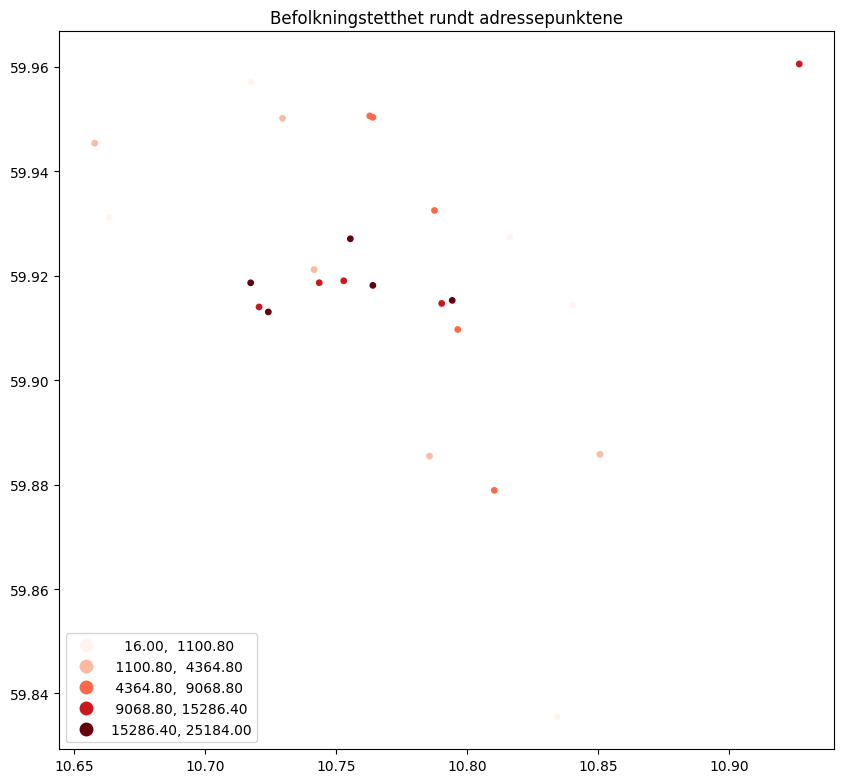

In [12]:
ax = adresser_med_befolkningsdata.plot(
    figsize=(10, 10),
    column="pop_density",
    cmap="Reds",
    scheme="quantiles",
    markersize=15,
    legend=True
)
ax.set_title("Befolkningstetthet rundt adressepunktene")

---

Vi kan bruke de samme argumentene for å plotte et befolkningstetthetskart ved hjelp av
hele `befolkningsnett` datasettet:

Text(0.5, 1.0, 'Befolkningstetthet i Oslo')

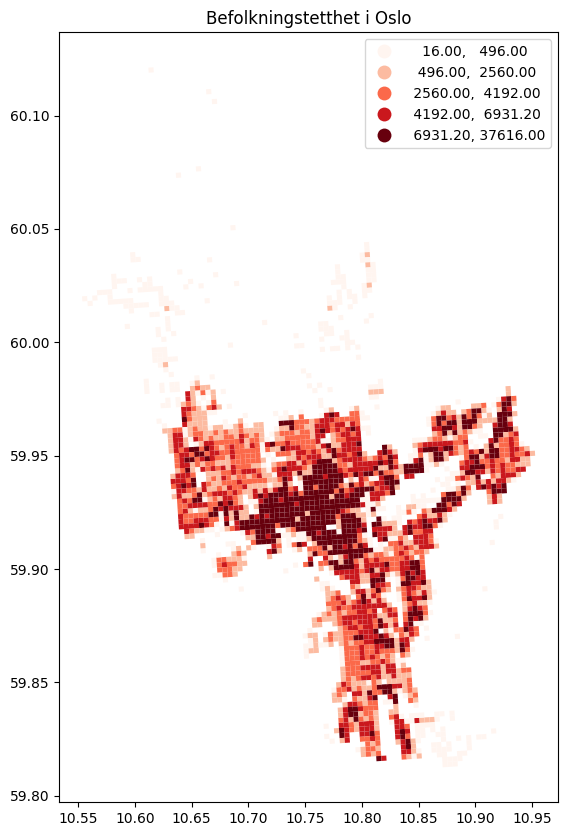

In [14]:
ax = befolkningsnett.plot(
    figsize=(10, 10),
    column="pop_density",
    cmap="Reds",
    scheme="quantiles",
    legend=True
)
ax.set_title("Befolkningstetthet i Oslo")


---


Til slutt, husk å lagre output dataframmen til en fil. Vi kan legge den til
den eksisterende *GeoPackage* ved å spesifisere et nytt lag navn:

In [16]:
adresser_med_befolkningsdata.to_file(
    DATA_MAPPE / "oslo_adresser" / "adresser.gpkg",
    layer="adresser_med_befolkningsdata"
)
